# CD-A Problem

Water content aus ERT-Daten abgeleitet.

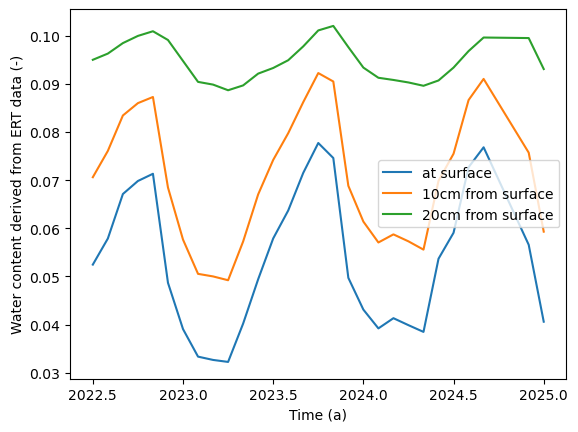

t_end = 78893968
plot interval = 788940


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

watercontent = pd.read_csv("watercontent.csv")

plt.plot(watercontent["time/a"], watercontent["0.00"], label="at surface")
plt.plot(watercontent["time/a"], watercontent["0.10"], label="10cm from surface")
plt.plot(watercontent["time/a"], watercontent["0.20"], label="20cm from surface")

plt.xlabel("Time (a)")
plt.ylabel("Water content derived from ERT data (-)")
plt.legend()
plt.show()

Nt = 100
tmax = max(watercontent["simtime"])
print(f"t_end = {tmax:.0f}")
print(f"plot interval = {(tmax/Nt):.0f}")

#
# Simulationsdauer und Plot-Intervall müssen manuell in die Projektdatei eingetragen werden.
# bei time_stepping -> maximum_dt, t_end
#


### Material and Problem parameter

The parameter for this problem are stored in a CSV file. Let's look at the table below. The column "Key" shows the parameter name in the PRJ file. The column "Value" shows current parameter value. The columns "Range min", "Range max" and "Scale" are used in the next section to define sliders to interact with the analytic solution.

In [ ]:
from helper import render_latex_table
#import pandas as pd

df = pd.read_csv("parameter.csv", quotechar="'")

# We look at this column later
df_OGSTools = df[["Key", "OGSTools"]]
df.drop('OGSTools', axis=1, inplace=True)

render_latex_table(df, latex_column="Symbol")

Property,Symbol,Key,Value,Range min,Range max,Scale,Unit
Porosity,$$ \varphi $$,phi,0.3,0.05,0.3,linear,1
Intrinsic permeability,$$ K $$,K,1.0000e-10,1.0000e-12,1.0000e-08,log,m²
Residual saturation of the wetting phase,"$$ S_\mathrm{w,r} $$",Swr,0.02,0.0,0.3,linear,1
Residual saturation of the non-wetting phase,"$$ S_\mathrm{n,r} $$",Snr,0.001,0.0,0.3,linear,1
Dynamic viscosity of the wetting phase,$$ \mu_\mathrm{n} $$,mun,0.001,0.0001,0.01,log,Pa·s
Dynamic viscosity of the non-wetting pha,$$ \mu_\mathrm{w} $$,muw,0.001,0.0001,0.01,log,Pa·s
Brooks and Corey model parameter: entry pressure,$$ p_\mathrm{e} $$,Pe,5000,1000,100000,log,Pa
Brooks and Corey model parameter: pore size distribution index,$$ \lambda $$,lambda_,3,1.5,3,linear,1
Initial saturation,$$ S_\mathrm{w}(t=0) $$,Si,0.2,0.0,0.5,linear,1
Injection boundary saturation,$$ S_\mathrm{w}(x=0) $$,S0,0.9,0.51,1,linear,1


<IPython.core.display.Javascript object>

In [ ]:
!pip install pyDOE3

from pyDOE3 import pbdesign
import numpy as np

num_parameter = df.shape[0]
design = pbdesign(num_parameter)

num_simulation = np.shape(design)[0]

parameter = df["Key"]
value_min = df["Range min"]
value_max = df["Range max"]

print(design)


print(f"\nThere are {num_parameter} parameters and {num_simulation} simulation runs.") 

[[ 1. -1.  1.  1.  1. -1. -1. -1.  1. -1.]
 [-1.  1.  1.  1. -1. -1. -1.  1. -1. -1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.  1.  1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1. -1.  1.  1.  1. -1. -1.]
 [-1. -1.  1. -1.  1.  1.  1. -1. -1. -1.]
 [-1.  1. -1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]

There are 10 parameters and 12 simulation runs.


In [ ]:
import json

replace_info = dict()

for index, row in df_OGSTools.iterrows():
    if row["OGSTools"] == "Parameter":
        replace_info[row["Key"]] = row["OGSTools"]
    else:
        replace_info[row["Key"]] = json.loads(row["OGSTools"])

# Add infos for calculated parameter
replace_info["pci"] = "Parameter"
replace_info["pc0"] = "Parameter"

#
# Hier muss die Info angepasst werden, die notwendig ist, um die pc0-Kurve zu schreiben.
# Dazu muss auch dir PRJ-Datei angepasst werden, so dass die Randbedingung als Kurve vorliegt.
#


{'phi': 0.3, 'K': 1e-12, 'Swr': 0.3, 'Snr': 0.3, 'mun': 0.01, 'muw': 0.0001, 'Pe': 1000.0, 'lambda_': 1.5, 'Si': 0.5, 'S0': 0.51}
{'phi': 0.05, 'K': 1e-08, 'Swr': 0.3, 'Snr': 0.3, 'mun': 0.0001, 'muw': 0.0001, 'Pe': 1000.0, 'lambda_': 3.0, 'Si': 0.0, 'S0': 0.51}
{'phi': 0.3, 'K': 1e-08, 'Swr': 0.3, 'Snr': 0.0, 'mun': 0.0001, 'muw': 0.0001, 'Pe': 100000.0, 'lambda_': 1.5, 'Si': 0.0, 'S0': 1.0}
{'phi': 0.3, 'K': 1e-08, 'Swr': 0.0, 'Snr': 0.0, 'mun': 0.0001, 'muw': 0.01, 'Pe': 1000.0, 'lambda_': 1.5, 'Si': 0.5, 'S0': 0.51}
{'phi': 0.3, 'K': 1e-12, 'Swr': 0.0, 'Snr': 0.0, 'mun': 0.01, 'muw': 0.0001, 'Pe': 1000.0, 'lambda_': 3.0, 'Si': 0.0, 'S0': 1.0}
{'phi': 0.05, 'K': 1e-12, 'Swr': 0.0, 'Snr': 0.3, 'mun': 0.0001, 'muw': 0.0001, 'Pe': 100000.0, 'lambda_': 1.5, 'Si': 0.5, 'S0': 1.0}
{'phi': 0.05, 'K': 1e-12, 'Swr': 0.3, 'Snr': 0.0, 'mun': 0.0001, 'muw': 0.01, 'Pe': 1000.0, 'lambda_': 3.0, 'Si': 0.5, 'S0': 1.0}
{'phi': 0.05, 'K': 1e-08, 'Swr': 0.0, 'Snr': 0.0, 'mun': 0.01, 'muw': 0.0001, 'Pe

## Numerical solutions

For the numerical solution, we compare the Thermal-2-Phase-Hydro-Mechanical (TH2M) and the Two-phase Flow formulation.

1. The first step is to create a matching mesh that capture the penetration depth of the wetting fluid. 
2. Because the OGS models use the capillary pressure as a primary variable, the boundary and initial conditions need to be converted from saturations to pressures.

Tip: Pick the parameters you would like to study with the sliders above and run the code blocks below to compare the results of the analytical and numerical model.

In [ ]:
from template import prj_from_template
from helper import create_1d_mesh, create_boundary_line_meshes

# Mesh for TwoPhaseFlowPP

depth = 0.5      # penetration depth of the wetting fluid (estimated!)
print(f"penetration depth of the wetting fluid: {depth}")

factor = 5.0   # mesh should be factor times larger than the depth 
Nel = 100         # number of mesh elements
mesh = create_1d_mesh(point_a=(0.0, 0.0, 0.0), point_b=(depth*factor, 0.0, 0.0), num_points=Nel+1, mesh_type="line")
mesh.save(r"mesh_line.vtu")

coords = {'x1': mesh.GetBounds()[0], 'x2': 0.5*mesh.GetBounds()[0]}
prj_from_template(coords, "mcwt.template", "mcwt.gml")


    # 1.3 Mesh for TH2M
    # mesh = create_1d_mesh(point_a=(0.0, 0.0, 0.0), point_b=(depth*factor, 0.0, 0.0), num_points=Nel+1, mesh_type="quad")
    # mesh.save(r"mesh_quad.vtu")

    # boundary_left, boundary_right = create_boundary_line_meshes(point_a=(0.0, 0.0, 0.0), point_b=(depth*factor, 0.0, 0.0), num_points=Nel+1)
    # boundary_left.save("boundary_left_test.vtu")                                   

    # Match element numbers in boundary mesh to domain mesh
    # !identifySubdomains -m mesh_quad.vtu -- boundary_left_test.vtu

In [ ]:
import pyvista as pv
import matplotlib.pyplot as plt
from mcwhorter import BrooksCorey, McWhorter
#from helper import create_1d_mesh, create_boundary_line_meshes
#from template import prj_from_template
import ogstools as ogs

#labels = ["TwoPhaseFlowPP", "TH2M"]
labels = ["TwoPhaseFlowPP"]
results = {l: [] for l in labels}

for sim in [0]: # np.arange(0, num_simulation): # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Zu Testzwecken modifiziert!

    params = {k: vmin if d < 0 else vmax for d, k, vmin, vmax in zip(design[sim,:], parameter, value_min, value_max)}
    print(params)

    # 1. Create meshes according to the penetration depth of the wetting fluid
    # 1.1 Calculate analytical solution to get penetration depth 

    #
    # An dieser Stelle können wir mit einem festen Gitter arbeiten,
    # da wir die depth kennen. max. 0.5m.
    # Zusätzlich muss noch ein Mesh erzeugt werden, dass die Infos enthält, dass Daten bei 0.1 und 0.2m rausgeschrieben werden sollen.
    # Entsprechend muss auch die PRJ-Datei angepasst werden.
    #

    model = BrooksCorey(params["Pe"], params["lambda_"], params["Snr"], params["Swr"])
    problem = McWhorter(model, params["phi"], params["K"], params["muw"], params["mun"], params["S0"], params["Si"])
    x_ref, Sw_ref = problem.get_solution()
    depth = max(x_ref)      # penetration depth of the wetting fluid
    print(f"penetration depth of the wetting fluid: {depth}")

    # 1.2 Mesh for TwoPhaseFlowPP
    factor = 5.0   # mesh should be factor times larger than the depth 
    Nel = 100         # number of mesh elements
    mesh = create_1d_mesh(point_a=(0.0, 0.0, 0.0), point_b=(depth*factor, 0.0, 0.0), num_points=Nel+1, mesh_type="line")
    mesh.save(r"mesh_line.vtu")

    coords = {'x1': mesh.GetBounds()[0], 'x2': 0.5*mesh.GetBounds()[0]}
    prj_from_template(coords, "mcwt.template", "mcwt.gml")

    # 1.3 Mesh for TH2M
    #mesh = create_1d_mesh(point_a=(0.0, 0.0, 0.0), point_b=(depth*factor, 0.0, 0.0), num_points=Nel+1, mesh_type="quad")
    #mesh.save(r"mesh_quad.vtu")

    #boundary_left, boundary_right = create_boundary_line_meshes(point_a=(0.0, 0.0, 0.0), point_b=(depth*factor, 0.0, 0.0), num_points=Nel+1)
    #boundary_left.save("boundary_left_test.vtu")                                   

    # Match element numbers in boundary mesh to domain mesh
    # !identifySubdomains -m mesh_quad.vtu -- boundary_left_test.vtu

    # 2. Calculate capillary pressures  
    params["pci"] = model.pc(params["Si"])
    params["pc0"] = model.pc(params["S0"])

    print(f"Si = {params['Si']} -> pci = {params['pci']}")
    print(f"S0 = {params['S0']} -> pc0 = {params['pc0']}")

    #
    # Hier muss die Berechnung von pc0 angepasst werden. 
    # S0 = watercontent["0.00"]/params["phi"]
    # params["pc0"] = model.pc(params["S0"])
    #    

    # 3. Updating the PRJ file and run simulations
    #prj_files = [r"mcWhorter_TwoPhasePP.prj", r"mcWhorter_TH2M.prj"]
    prj_files = [r"CD-A_TwoPhasePP.prj"]

    for prj_file in prj_files:
        prj = ogs.Project(input_file=prj_file, output_file=prj_file)
        for key in params.keys():
            try:
                if replace_info[key] == "Parameter":
                    prj.replace_parameter_value(name=key, value=params[key])
                else:
                    for r in replace_info[key]:
                        prj.replace_medium_property_value(mediumid=r["medium id"],
                                                        name=r["name"],
                                                        value=params[key],
                                                        propertytype=r["propertytype"],
                                                        valuetag=r["valuetag"])
            except:
                print(f"Parameter {key} not found...")
        prj.write_input()        
        prj.run_model()

    #
    # Ggf. muss der Code so angepasst werden, dass man auch Curves schreiben kann.
    #
    #

    
    # 4. Evaluate results
    #resultfiles = ["twophaseflow_test_t_1000.000000.vtu", "result_McWhorter_H2_ts_110_t_1000.000000.vtu"]
    resultfiles = ["twophaseflow_test_t_1000.000000.vtu"]


    for label, resultfile in zip(labels, resultfiles):

        mesh = pv.read(resultfile)
        Sw=mesh["saturation"]
        x=mesh.points[:,0]

        ind = np.argsort(x)
        x = x[ind]
        Sw = Sw[ind]

        plt.plot(x_ref, Sw_ref, label="Analytical solution")
        plt.plot(x, Sw, label=label)

        #
        # Die Auswertung muss so angepasst werden.
        # Dazu müssen die simulierten Daten eingelesen werden.
        # 
        # plt.plot(watercontent["simtime"], watercontent["0.10"]/params["phi"], "C0-", label="10cm from surface (ERT)")    
        # plt.plot(watercontent["simtime"], watercontent["0.20"]/params["phi"], "C1-", label="20cm from surface (ERT)")
        # plt.plot(tsim, Sw10, "C0--", label="10cm from surface (Sim)")
        # plt.plot(tsim, Sw20, "C1--", label="20cm from surface (Sim)")
        #

        plt.legend()
        plt.show()

        #
        # Hier muss ggf. etwas angepasst werden, was besser für die Interpretation der Ergebnisse passt.
        #
        #
 
        results[label].append(np.linalg.norm(Sw - np.interp(x, x_ref, Sw_ref)))





penetration depth of the wetting fluid: 0.7370002578514665
2 replacements made.
Si = 0.2 -> pci = 8549.879733383485
S0 = 0.9 -> pc0 = 5178.720843256431


Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Finally, we can update the PRJ file and run the simulations.

## Evaluation and Results

In [ ]:
def calculate_effects_and_stddev(design, results):
    results = np.array(results)
    num_factors = design.shape[1]
    effects = []
    stddevs = []
    for i in range(num_factors):
        high = results[design[:, i] == 1]
        low = results[design[:, i] == -1]
        effect = (high.mean() - low.mean())  # Effekt
        stddev = np.sqrt(np.var(high) + np.var(low))  # Standardabweichung
        effects.append(effect)
        stddevs.append(stddev)
    return effects, stddevs

def plot_effects_with_errorbars(effects, stddevs, labels, title):
   
    # sort parameters according to effect size
    sorted_indices = np.argsort(np.abs(effects))[::-1]
    sorted_effects = np.array(effects)[sorted_indices]
    sorted_stddevs = np.array(stddevs)[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]
    
    # plot with error bars
    plt.bar(sorted_labels, sorted_effects, yerr=sorted_stddevs, capsize=5, color="blue", alpha=0.7)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(title)
    plt.ylabel("effect size")
    plt.xlabel("parameter")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for l in labels:
    effects, stddevs = calculate_effects_and_stddev(design, results[l])
    plot_effects_with_errorbars(effects, stddevs, labels=parameter, title=l)
    plt.show()

## Literature

- McWhorter, D. B., and D. K. Sunada (1990), Exact integral solutions for two-phase flow, Water Resour. Res., 26(3), 399–413, <cite>[doi:10.1029/WR026i003p00399][1]</cite>. 
- Radek Fučík, https://mmg.fjfi.cvut.cz/~fucik/index.php?page=exact

[1]: https://doi.org/10.1029/WR026i003p00399
